In [1]:
import http.client
import pandas as pd
import pprint
import collections

start_date='01/01/2019'
end_date='01/01/2030'

url = "https://ptax.bcb.gov.br/ptax_internet/consultaBoletim.do?method=gerarCSVFechamentoMoedaNoPeriodo&ChkMoeda=61&DATAINI={start}&DATAFIM={end}".format(start=start_date, end=end_date)

retry = 5
while retry != 0:
  try:
    data = pd.read_csv(url, header=None, sep=";", dtype=str)
    break
  except http.client.RemoteDisconnected:
    retry -= 1
    
data

,0,1,2,3,4,5,6,7
0,02012019,220,A,USD,"3,8589","3,8595","1,0000","1,0000"
1,03012019,220,A,USD,"3,7677","3,7683","1,0000","1,0000"
2,04012019,220,A,USD,"3,7621","3,7627","1,0000","1,0000"
3,07012019,220,A,USD,"3,7056","3,7062","1,0000","1,0000"
4,08012019,220,A,USD,"3,7202","3,7208","1,0000","1,0000"
...,...,...,...,...,...,...,...,...
382,09072020,220,A,USD,"5,2972","5,2978","1,0000","1,0000"
383,10072020,220,A,USD,"5,3434","5,3440","1,0000","1,0000"
384,13072020,220,A,USD,"5,3480","5,3486","1,0000","1,0000"
385,14072020,220,A,USD,"5,4282","5,4288","1,0000","1,0000"


In [2]:
from datetime import datetime

rates = {}
for row in data.to_numpy():
    row_date = datetime.strptime(row[0], "%d%m%Y").strftime("%Y-%m-%d")
    row_value = {"BRL": float(row[5].replace(",","."))}
    rates[row_date] = row_value

In [3]:
def group_by_month(dictionary):
    output = {}
    for key in dictionary:
        month_key = key[:7]
        day = int(key[8:])
        if month_key in output:
            rate_list = output[month_key]
            rate_list[day] = dictionary[key]['BRL']
            output[month_key] = rate_list
        else:
            output[month_key] = {day: dictionary[key]['BRL']}
    return output

def normalize_values(dictionary, min_value, max_value):
    output = dictionary.copy()
    delta = max_value - min_value
    for key in output:
        value = output[key]
        if (delta != 0):
            output[key] = (value - min_value)/delta
        else:
            output[key] = 1
    return output
        

def make_rates_relative(dictionary):
    grouped_rates = dictionary.copy()
    for key in grouped_rates:
        values = grouped_rates[key]
        min_rate = 10000
        max_rate = -1
        for day_key in values:
            rate = values[day_key]
            if rate < min_rate:
                min_rate = rate
            if rate > max_rate:
                max_rate = rate
        grouped_rates[key] = normalize_values(values, min_rate, max_rate)
    return grouped_rates
            

grouped_values = group_by_month(rates)
normalized_values = make_rates_relative(grouped_values)
# pprint.pprint(normalized_values)
# pprint.pprint(grouped_values)

In [4]:
# Get current month and prepare it for plot
from datetime import datetime

current_month_key = datetime.now().strftime("%Y-%m")
month_x, month_y = zip(*list(grouped_values[current_month_key].items()))

In [5]:
def group_by_day(month_dict):
    output = {}
    for month in month_dict:
        month_value = month_dict[month]
        for day in month_value:
            rate = month_value[day]
            if day in output:
                output[day].append(rate)
            else:
                output[day] = [rate]
    return output

values_per_day = group_by_day(normalized_values)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import operator
import numpy as np

data = {}
for key in values_per_day:
    value = values_per_day[key]
    data[key] = sum(value)/len(value)

lists = sorted(data.items()) # sorted by key, return a list of tuples

ordered_by_value = sorted(data.items(), key = operator.itemgetter(1),reverse = True)

The Relative Value is between the min and max USD->BRL values in a given month




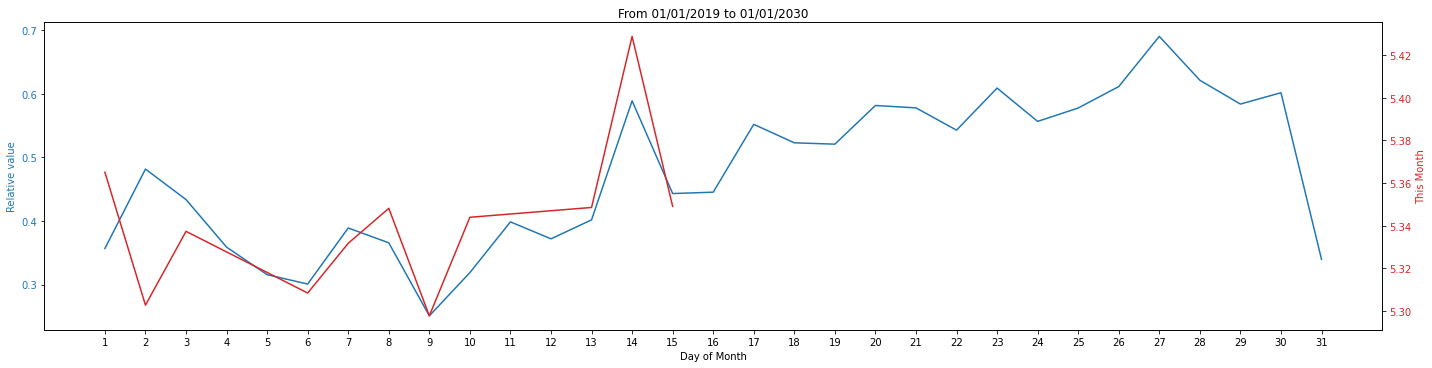

The day with HIGHEST value probability is the 27 with a value of 0.6900857715619041
The day with LOWEST value probability is the 9 with a value of 0.25096883631811945


In [7]:
x, y = zip(*lists) # unpack a list of pairs into two tuples

print('The Relative Value is between the min and max USD->BRL values in a given month\n\n')

fig, ax1 = plt.subplots(figsize=(20,5))

color = 'tab:blue'
ax1.set_xlabel('Day of Month')
ax1.set_ylabel('Relative value', color=color)
# ax1.ylim((0,1))
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('This Month', color=color)  # we already handled the x-label with ax1
ax2.plot(month_x, month_y, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title(label="From {start} to {end}".format(start=start_date, end=end_date))
plt.show()

best_day = ordered_by_value[0]
print('The day with HIGHEST value probability is the ' + str(best_day[0]) + ' with a value of ' + str(best_day[1]))
worst_day = ordered_by_value[-1]
print('The day with LOWEST value probability is the ' + str(worst_day[0]) + ' with a value of ' + str(worst_day[1]))